In [1]:
import os
from keras import layers
from keras import models
from keras import optimizers
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
import tensorflow as tf
from keras.layers import Dense, Activation, Flatten

Using TensorFlow backend.


In [2]:
# importing data
base_dir = '/home/minool/Documents/Projects/MachineLearning/HW3/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


In [3]:
# Convnet
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


x = Flatten(name='flatten')(conv_base.output)
x = Dense(256, activation='relu', name='fc1')(x)
x = Dense(2, activation='softmax', name='predictions')(x)

# stitch together
model = models.Model(inputs= conv_base.input, outputs=x)

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # fill_mode='nearest',
    zca_whitening=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical')

/home/minool/.local/lib/python2.7/site-packages/keras_preprocessing/image.py:836: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
# Fine Tuning
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        layer.trainable = True
    else:
        layer.trainable = False
        

In [5]:
# compile model

model.compile(
    loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

# train

history = model.fit_generator(train_generator,steps_per_epoch=100,epochs=5,validation_data=validation_generator,
    validation_steps=50)

Epoch 1/5


/home/minool/.local/lib/python2.7/site-packages/keras_preprocessing/image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/minool/.local/lib/python2.7/site-packages/keras_preprocessing/image.py:1150: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


100/100 [==============================] - 28s 284ms/step - loss: 0.6300 - acc: 0.6470 - val_loss: 0.5172 - val_acc: 0.7610
Epoch 2/5
100/100 [==============================] - 25s 253ms/step - loss: 0.5290 - acc: 0.7340 - val_loss: 0.4403 - val_acc: 0.8020
Epoch 3/5
100/100 [==============================] - 25s 251ms/step - loss: 0.4834 - acc: 0.7745 - val_loss: 0.3727 - val_acc: 0.8340
Epoch 4/5
100/100 [==============================] - 25s 252ms/step - loss: 0.4496 - acc: 0.7930 - val_loss: 0.3131 - val_acc: 0.8720
Epoch 5/5
100/100 [==============================] - 25s 252ms/step - loss: 0.4080 - acc: 0.8110 - val_loss: 0.2798 - val_acc: 0.8880


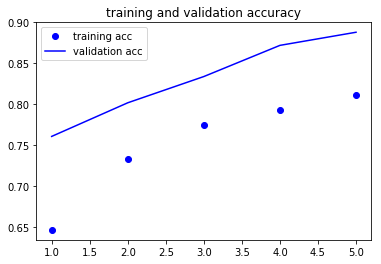

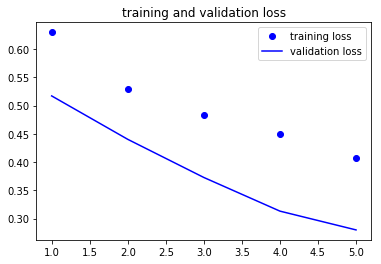

In [6]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [8]:
last_conv_layer = model.get_layer('block5_conv4')

In [9]:
def show_superimposed_image(img_path, heatmap):

    img = cv2.imread(img_path)
    # resize the heatmap to be the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    cv2.imshow('',superimposed_img)


In [19]:
def process_image(img_path, idx=0):
    img = image.load_img(img_path, target_size=(224, 224))
    #
    plt.imshow(img)
    plt.grid(None)
    plt.show()
    #
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    #
    preds = model.predict(x)
    print preds
    #
    class_index = np.argmax(preds[0])
    print class_index
    
    class_output = model.output[:, class_index]
    print class_output
    last_conv_layer = model.get_layer('block5_conv4')
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    
    print grads
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    print pooled_grads
    
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    
    pooled_grads_value, conv_layer_output_value = iterate([x])
    print conv_layer_output_value
    print pooled_grads_value
#     for i in range(512):
#         conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    print heatmap
    plt.matshow(heatmap)
    plt.grid(None)
    plt.show()
    #
#     show_superimposed_image(img_path, heatmap)


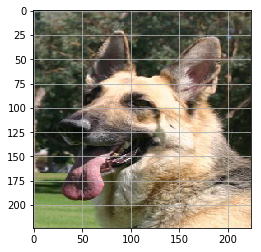

[[0. 1.]]
1
Tensor("strided_slice_10:0", shape=(?,), dtype=float32)
Tensor("gradients_5/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(?, 14, 14, 512), dtype=float32)
Tensor("Mean_5:0", shape=(512,), dtype=float32)
[[[ 0.         0.         0.        ...  0.         8.1226635  0.       ]
  [ 0.         0.         0.        ...  0.         3.7031643  0.       ]
  [ 0.         0.         0.        ...  0.         4.713699   0.       ]
  ...
  [ 0.         0.         0.        ...  0.         0.        12.472087 ]
  [ 0.         0.         0.        ...  0.         0.         5.771267 ]
  [ 0.         0.         0.        ...  0.         0.         2.458397 ]]

 [[ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  ...
  [ 0.         0.         0.        ...  0.         0.         3.41973  ]
  [ 0.         0.         0.  

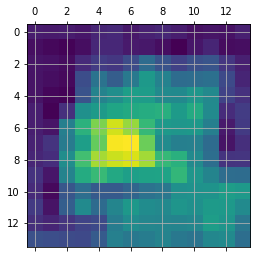

In [20]:

img_path1 = '/home/minool/Documents/Projects/MachineLearning/HW3/dog.jpg'
process_image(img_path1)